In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
# Statistical analysis
from scipy import stats
from numpy import mean

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
from sqlalchemy import create_engine, inspect, func
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

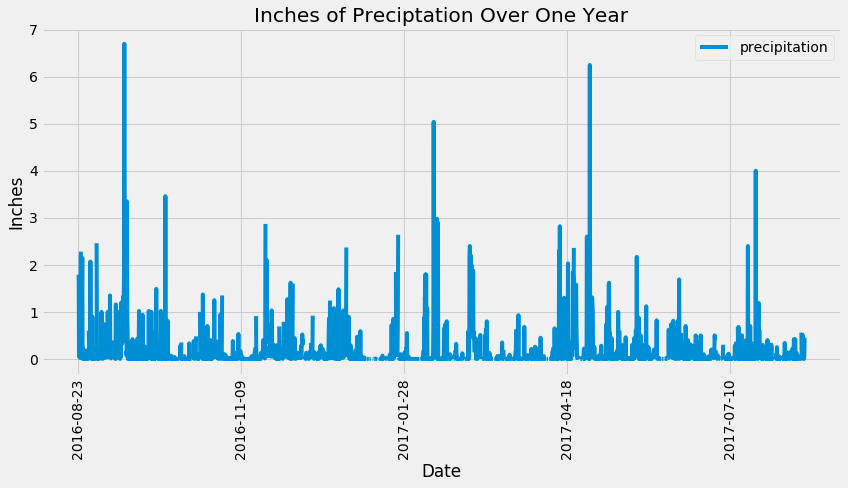

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.id,
       Measurement.station,
       Measurement.date,
       Measurement.prcp,
       Measurement.tobs]

prec_year = session.query(*sel).\
    filter(Measurement.date >= year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
measurement_df = pd.DataFrame(prec_year,columns=['id','station','date','prcp','tobs'])
measurement_df = measurement_df[['date','prcp']]
measurement_df.set_index('date', inplace=True)

# Sort the dataframe by date
measurement_sorted_df = measurement_df.sort_values(by=['date'])

# Use Pandas Plotting with Matplotlib to plot the data
measurement_sorted_df.plot.line(figsize=(12,7))

plt.title("Inches of Preciptation Over One Year")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(rotation=90)
plt.legend(["precipitation"],loc="best")
plt.tight_layout()
plt.show()

In [12]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
measurement_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
station_cnt = session.query(Station).group_by(Station.id).count()
print(f"There are {station_cnt} stations.")

There are 9 stations.


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [Measurement.station,
       func.count(Measurement.tobs)]

observation_cnts = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).all()

observation_cnts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
highest_obs_station = session.query(Measurement).filter(Measurement.station == "USC00519281")

temp_list = []
for temp in highest_obs_station:
    temp_list.append(temp.tobs)
    
lowest_temp = min(temp_list)
highest_temp = max(temp_list)
avg_temp = mean(temp_list)

print(f"The lowest temperature for USC00519281 is {lowest_temp}.")
print(f"The highest temperature for USC00519281 is {highest_temp}.")
print(f"The average temperature for USC00519281 is {avg_temp}.")

The lowest temperature for USC00519281 is 54.0.
The highest temperature for USC00519281 is 85.0.
The average temperature for USC00519281 is 71.66378066378067.


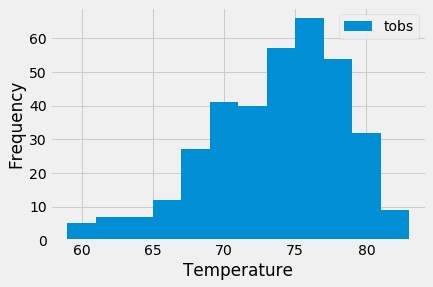

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
latest_date_obs = session.query(Measurement.date).\
    filter(Measurement.station == "USC00519281").\
    order_by(Measurement.date.desc()).first()

year_ago_obs = dt.date(2017, 8, 18) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
sel_obs = [Measurement.id,
       Measurement.station,
       Measurement.date,
       Measurement.prcp,
       Measurement.tobs]

temp_year = session.query(*sel_obs).\
    filter(Measurement.date >= year_ago_obs).\
    filter(Measurement.station == "USC00519281").all()

# Save the query results as a Pandas DataFrame and set the index to the date column
temperature_df = pd.DataFrame(temp_year,columns=['id','station','date','prcp','tobs'])
temperatures = temperature_df['tobs']

plt.hist(temperatures,bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(['tobs'], loc='best')
plt.show()

## Bonus Challenge Assignment

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [22]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [26]:
# Plot the daily normals as an area plot with `stacked=False`
